#<center>python 文档聚类和主题建模

<center>易红发 yihongfa@yeah.net

文档聚类和文本分类是文本挖掘的基本任务，本文主要针对的是无监督的聚类算法，包括K-means聚类、谱系聚类和LDA主题建模。  
Python环境下对文本的处理主要用到以下模块：nltk、pandas、sklearn、gensim等。  
对于想利用Python来处理文本的挖掘者来说，本文应该是不错的借鉴。

本文的主要任务是通过电影简介为电影聚类，数据可在[此处](https://github.com/yihongfa/pythondata/tree/master/data)下载。分为title、synopses和genres三部分。

In [1]:
#导入要用到的模块
import numpy as np
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from sklearn import feature_extraction

# 数据预处理

In [2]:
#导入三部分数据：电影名列表、链接以及简介，支取前100部电影
titles = open('title_list.txt').read().split('\n')
#保证只有前一百条被读入
titles = titles[:100]

synopses = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses = synopses[:100]

In [3]:
#清洗电影简介
synopses_clean = []
for text in synopses:
    text = BeautifulSoup(text, 'html.parser').getText()
    #将html格式的转化为无格式文本（unicode）
    synopses_clean.append(text)

synopses = synopses_clean

In [4]:
titles[:5]#查看前5部电影的电影名

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca']

In [5]:
synopses[0][:200]#查看第一条简介的前200个字符

u" Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son,"

In [6]:
#导入电影类型数据
genres = open('genres_list.txt').read().split('\n')
genres =genres[:100]

In [8]:
#总览所有数据
print(str(len(titles)) + ' titles')
print(str(len(synopses)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 synopses
100 genres


In [9]:
#生成索引
ranks = []
for i in range(0,len(titles)):
    ranks.append(i)

通过nltk清洗数据

In [10]:
#导入nltk英文止停词
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
#导入 SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

下文将定义两种函数：

<ul>
<li>tokenize_and_stem: 分词并且将词“词干化”，所谓“词干化”是将单词根据词根归一，比如take和took，经过“词干化”均表示为take。
<li>tokenize_only: 只分词。
</ul>

In [12]:
def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    #过滤掉非字母，比如数字和间隔等
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
        

用词干化和未词干化的结果构建DataFrame，这样使得后文的分析更为精确。虽然是文档聚类，其实最小单位还是词，词准确了，聚类才会准确。

In [13]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

# TF-IDF模型和文档相似度

本部分的主要内容是将原始文档映射到词向量空间，形成TF-IDF，并计算文档相似度或距离。

In [14]:
#通过scikit-learn中的文本特征抽取模块中的TF-IDF向量模型进行文档向量化。
#其中max_df=0.8和min_df=0.2的意思是过滤掉文档频率高于80%和文档频率低于20%的词。
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                  min_df=0.2, stop_words='english',
                                  use_idf=True, tokenizer=tokenize_and_stem,
                                  ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

In [15]:
terms = tfidf_vectorizer.get_feature_names()#获取词（特征）名

In [16]:
terms[:5]

[u'accept', u'agre', u'allow', u'alon', u'american']

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [18]:
dist[1,9] #某两个文档的距离

0.82470069219035791

# K-means 聚类

利用TF-IDF向量空间和文档距离

In [19]:
#利用scikit-learn中的Kmeans模型进行聚类，类别数为5
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [20]:
clusters[:10]#前10个文档的类

[4, 0, 3, 1, 0, 3, 3, 1, 1, 3]

In [21]:
#构造数据框
import pandas as pd

films = {'title':titles, 'rank':ranks, 'synopses':synopses, 'cluster':clusters, 'genre':genres}

frame = pd.DataFrame(films, index=[clusters], columns=['rank', 'title', 'cluster', 'genre'])

In [22]:
frame['rank'] += 1 

In [23]:
frame.to_excel('cluster.xlsx') #结果写入文件

In [24]:
frame #聚类结果

,rank,title,cluster,genre
4,1,The Godfather,4,"[u' Crime', u' Drama']"
0,2,The Shawshank Redemption,0,"[u' Crime', u' Drama']"
3,3,Schindler's List,3,"[u' Biography', u' Drama', u' History']"
1,4,Raging Bull,1,"[u' Biography', u' Drama', u' Sport']"
0,5,Casablanca,0,"[u' Drama', u' Romance', u' War']"
3,6,One Flew Over the Cuckoo's Nest,3,[u' Drama']
3,7,Gone with the Wind,3,"[u' Drama', u' Romance', u' War']"
1,8,Citizen Kane,1,"[u' Drama', u' Mystery']"
1,9,The Wizard of Oz,1,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
3,10,Titanic,3,"[u' Drama', u' Romance']"


#谱系聚类

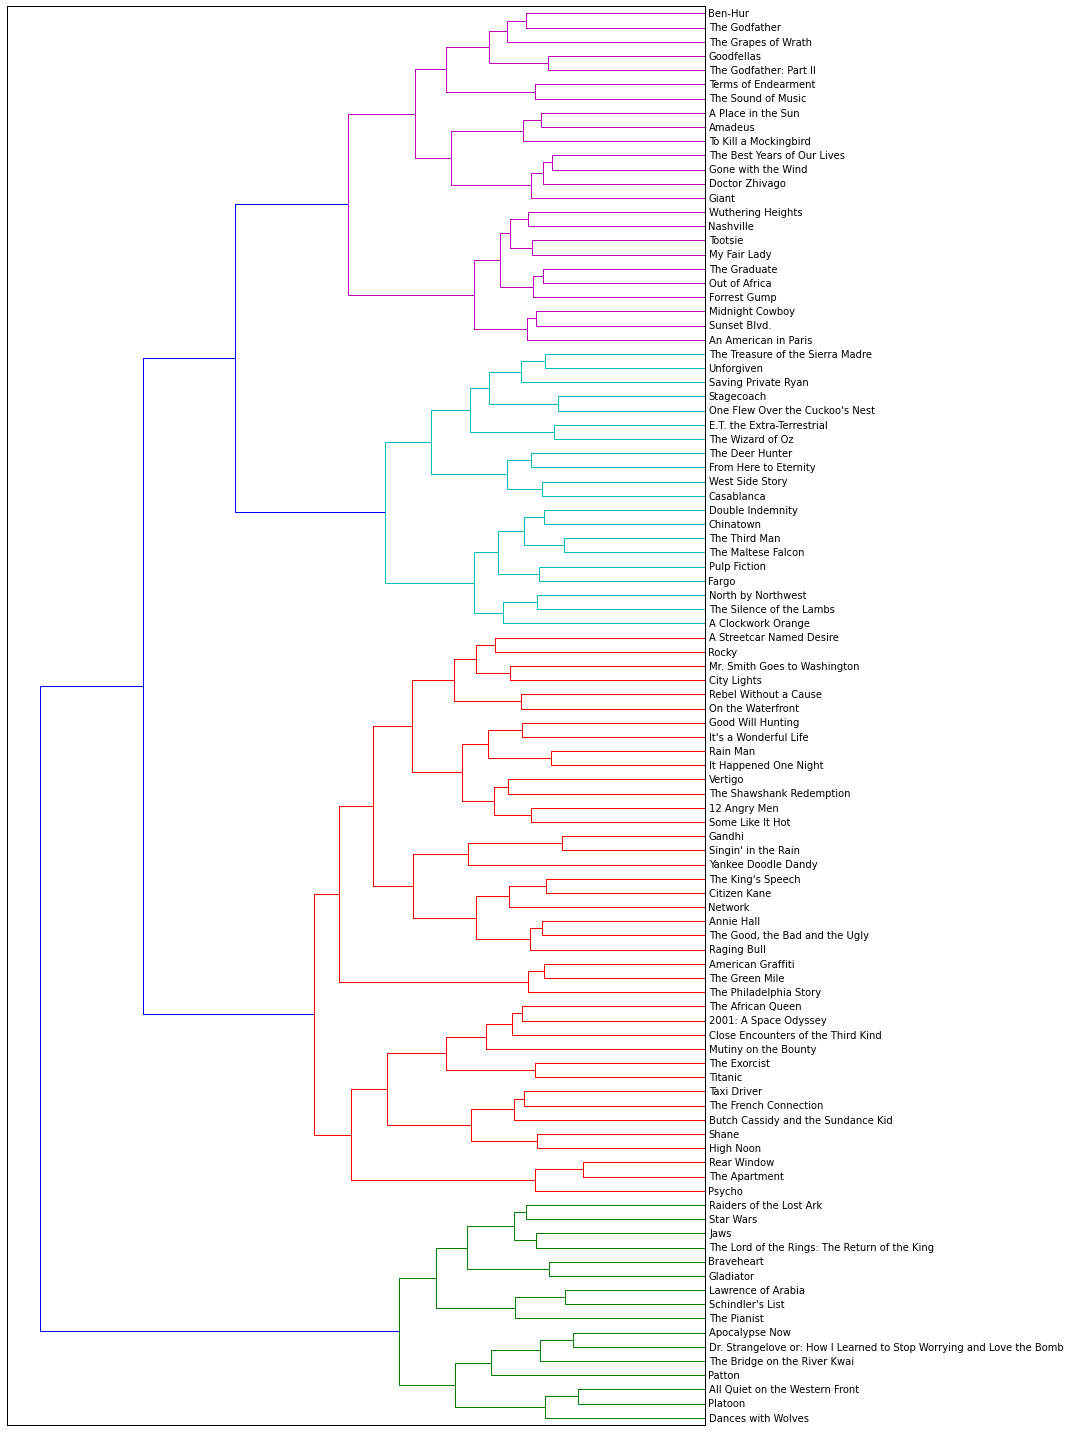

In [25]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
%matplotlib inline

linkage_matrix = ward(dist) #通过ward法构建矩阵

fig, ax = plt.subplots(figsize=(15,20))
ax = dendrogram(linkage_matrix, orientation='right', labels=titles)

plt.tick_params(axis= 'x',          
                which='both',      
                bottom='off',      
                top='off',         
                labelbottom='off')

plt.tight_layout() #紧凑布局

#保存图像
plt.savefig('ward_clusters.png', dpi=200) 

# LDA主题建模

LDA主题建模需要并不依赖TF-IDF模型，所以需要重新进行数据预处理

In [26]:
#分词
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [27]:
#文本准备
from gensim import corpora, models, similarities

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

tokenized_text = [tokenize_and_stem(text) for text in preprocess]

texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

In [31]:
#词典和语料库准备
dictionary = corpora.Dictionary(texts) #构造词典
dictionary.filter_extremes(no_below=1, no_above=0.8)#去高频词

corpus = [dictionary.doc2bow(text) for text in texts] #构造语料库

In [32]:
len(corpus)

100

In [33]:
#训练一个LDA模型
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

Wall time: 2min 55s


In [34]:
print(lda[corpus[0]])#打印第一个文档的主题建模结果

[(3, 0.99856435945125999)]


In [35]:
topics = lda.print_topics(5, num_words=20)#结果中的主题

In [36]:
topics #主题

[u'0.006*kill + 0.006*take + 0.005*return + 0.005*back + 0.005*shark + 0.004*home + 0.004*befor + 0.004*polic + 0.004*arriv + 0.004*tri + 0.004*find + 0.004*famili + 0.004*discov + 0.003*order + 0.003*one + 0.003*father + 0.003*attack + 0.003*make + 0.003*command + 0.003*learn',
 u'0.007*kill + 0.005*tell + 0.005*famili + 0.005*man + 0.005*leav + 0.005*find + 0.004*friend + 0.004*return + 0.004*life + 0.004*back + 0.004*order + 0.004*fight + 0.004*take + 0.003*arriv + 0.003*first + 0.003*make + 0.003*prison + 0.003*way + 0.003*meet + 0.003*ask',
 u'0.006*kill + 0.005*find + 0.005*take + 0.005*return + 0.004*man + 0.004*time + 0.004*say + 0.004*tell + 0.004*vote + 0.004*ask + 0.004*home + 0.004*befor + 0.004*friend + 0.004*one + 0.003*make + 0.003*night + 0.003*onli + 0.003*begin + 0.003*love + 0.003*murder',
 u'0.006*leav + 0.005*get + 0.005*tell + 0.005*make + 0.004*home + 0.004*take + 0.004*love + 0.004*tri + 0.004*kill + 0.004*arriv + 0.004*find + 0.004*go + 0.004*back + 0.004*fight

In [37]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [38]:
topics_matrix = np.array(topics_matrix)

In [39]:
topics_matrix #主题矩阵

array([[[u'0.00593728051897', u'kill'],
        [u'0.0055825257252', u'take'],
        [u'0.00496062793487', u'return'],
        [u'0.00483481306431', u'back'],
        [u'0.00480556317119', u'shark'],
        [u'0.0044004127217', u'home'],
        [u'0.00419618701223', u'befor'],
        [u'0.0041661085672', u'polic'],
        [u'0.00394552565961', u'arriv'],
        [u'0.00388931191125', u'tri'],
        [u'0.00384788046479', u'find'],
        [u'0.00367382009423', u'famili'],
        [u'0.00358706714583', u'discov'],
        [u'0.00349972303922', u'order'],
        [u'0.00346444201506', u'one'],
        [u'0.00345468490397', u'father'],
        [u'0.00332564867337', u'attack'],
        [u'0.00332556499353', u'make'],
        [u'0.00315155482136', u'command'],
        [u'0.00311890645064', u'learn']],

       [[u'0.00715837199668', u'kill'],
        [u'0.00535375220484', u'tell'],
        [u'0.00499557447521', u'famili'],
        [u'0.00499304368397', u'man'],
        [u'0.0049384907